In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import gget
import scanpy as sc
import anndata as an
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import zscore
import scipy
from scipy.sparse import csr_matrix 

sc.settings.verbosity = 3  

# Load sc data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.X = adata.layers['raw_counts'].copy()

sc.pp.normalize_total(
        adata, 
        target_sum=1e6,
        key_added='norm_factor',
)

adata.layers["cpm"] = adata.X.copy()
sc.pp.log1p(adata)

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'norm_factor'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts', 'cpm'
    obsp: 'connectivities', 'distances'

# Load isoforms

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/isoforms/isoform_data.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df = df[df['cell_id'].isin(adata.obs_names)] # filter out undetected CBs

# add nulti-map flag
df['n_isoforms'] = df.groupby('gene_name')['transcript_name'].transform('nunique')

# drop genes that don't express multiple isoforms
df = df[df['n_isoforms'] > 1]
df['value'] = 1
print(f"{df.shape=}")
df.head()

df.shape=(47827803, 8)
df.shape=(41870261, 10)


,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name,n_isoforms,value
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204,5,1
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204,5,1
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204,5,1
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202,5,1
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202,5,1


In [4]:
def drop_cols_below_threshold(df, threshold):
    """
    Drops columns from a DataFrame where the column sum is less than a threshold.

    Args:
        df: The pandas DataFrame.
        threshold: The threshold value for the column sum.

    Returns:
        The modified DataFrame with columns dropped.
    """
    # Calculate column sums
    col_sums = df.sum(axis=0)  # Sum along rows (axis=0)

    # Identify columns to drop
    cols_to_drop = col_sums[col_sums < threshold].index

    # Drop columns
    df.drop(cols_to_drop, axis=1, inplace=True)  # Drop along columns (axis=1)

    return df


# create a cell x transcript matrix
X_iso = pd.pivot_table(
    df, 
    index='cell_id',
    columns='transcript_name',
    values='value',
    aggfunc='sum',
    fill_value=0.0,
)

print(f"{X_iso.shape=}")
threshold = 5

X_iso = drop_cols_below_threshold(X_iso, threshold)
print(f"{X_iso.shape=}")

X_iso.shape=(8563, 81229)
X_iso.shape=(8563, 48564)


In [5]:
X_iso.head()

transcript_name,A1BG-202,A1BG-203,A1BG-204,A2M-201,A2M-206,A2M-207,A4GALT-201,A4GALT-202,A4GALT-206,A4GALT-207,...,ZYX-209,ZZEF1-201,ZZEF1-204,ZZEF1-208,ZZEF1-210,ZZZ3-202,ZZZ3-204,ZZZ3-205,ZZZ3-210,ZZZ3-211
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGAAGT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGAAGCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGGAGGTT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Structure the gene expression datas

In [6]:
X_gene = adata.to_df()
print(f"{X_gene.shape=}")
X_gene = drop_cols_below_threshold(X_gene, threshold)
print(f"{X_gene.shape=}")
X_gene.head()

X_gene.shape=(8563, 15065)
X_gene.shape=(8563, 15065)


,ATAD3B,SKI,PEX14,PLCH2,SPSB1,HES3,PLEKHM2,CA6,NMNAT1,CCDC27,...,TSPY4,TSPY9,KDM5D,RBMY1F,BPY2C,CDY2B,SRY,VCY,DAZ1,RBMY1E
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,5.033606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.033606,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,6.415002,0.0,0.0
AAACCCAAGTTGAAGT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,5.210664,0.000000,0.0,0.0,0.0,0.000000,6.305631,0.0,0.0
AAACCCAAGTTGTCGT,0.0,5.446508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,5.446508,5.446508,0.0,0.0
AAACCCACAGAAGCGT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,5.675138,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
AAACCCACAGGAGGTT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,4.252978,4.252978,0.0,0.0,0.0,0.000000,5.342063,0.0,0.0


# PCA

,test1,test2,test3,test4,test5
cell_id,,,,,
AAACCCAAGGTTACCT,201.703796,-22.850645,-30.996105,-27.061663,163.098389
AAACCCAAGTTGAAGT,197.414047,-57.761112,173.725372,-30.595224,-3.380917
AAACCCAAGTTGTCGT,161.429520,83.394104,-2.693167,-47.408134,-51.745567
AAACCCACAGAAGCGT,160.616180,85.166191,6.897591,-14.702385,-10.108000
AAACCCACAGGAGGTT,238.640091,-74.544029,-63.363483,-58.246288,-70.353889
AAACCCAGTACCTAAC,216.234299,-41.754498,-55.600159,-45.285873,-11.584230
AAACCCATCAGGACGA,210.288635,-71.639542,-15.538626,143.192535,-25.770901
AAACCCATCTTACGGA,122.975952,15.586741,-0.154962,-2.530896,0.152369
AAACGAAAGATACAGT,160.751526,69.761215,5.020159,78.274284,8.876943


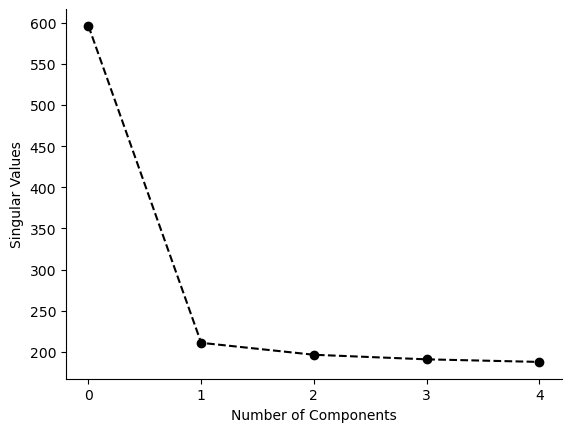

In [7]:
def get_first_n_pcs_sparse(df, n_components, col_prefix='PC', plot_scree=True):
    """
    Computes and returns the first n principal components from a DataFrame using Truncated SVD for sparse data.
    Preserves the original index in the output. Optionally plots a scree plot of explained variance.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        n_components (int): The number of principal components to compute.
        col_prefix (str, optional): Prefix for the output column names. Defaults to 'PC'.
        plot_scree (bool, optional): Whether to plot the scree plot. Defaults to True.

    Returns:
        pandas.DataFrame: A DataFrame containing the first n principal components, with the original index preserved.
    """

    # Convert DataFrame to sparse matrix
    sparse_matrix = csr_matrix(df.values)

    # Initialize Truncated SVD
    svd = TruncatedSVD(n_components=n_components)

    # Fit and transform the sparse matrix
    principal_components = svd.fit_transform(sparse_matrix)

    # Create a DataFrame with the principal components and original index
    pc_cols = [f'{col_prefix}{i+1}' for i in range(n_components)]
    pc_df = pd.DataFrame(data=principal_components, columns=pc_cols, index=df.index)
    
    # Plot scree plot if flag is True
    if plot_scree:
        n = min(n_components, len(svd.singular_values_))
        plt.plot(
            range(n),
            svd.singular_values_[:n],
            marker='o', 
            markeredgecolor='k',
            c='k',
            linestyle='--',
        )
        plt.xlabel('Number of Components')
        plt.ylabel('Singular Values')
        sns.despine()
        plt.xticks(range(n)) 

    return pc_df

n_components = 5
get_first_n_pcs_sparse(
    X_gene.head(10), 
    n_components=n_components,
    col_prefix='test',
)

# SAVE THE UNIVERSE

gene_pca.shape=(8563, 35)


,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene26,gene27,gene28,gene29,gene30,gene31,gene32,gene33,gene34,gene35
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,192.062912,4.664567,-5.899775,-12.748454,6.426852,-1.661416,-4.134886,-11.799650,-8.566000,5.211744,...,6.090026,8.476567,3.375809,-3.741421,1.167052,0.707391,5.433815,-1.702396,-8.142462,3.668827
AAACCCAAGTTGAAGT,183.349106,13.357903,-2.273727,-21.223257,15.253170,-4.236595,2.443233,-2.898249,1.045827,5.174258,...,-2.133430,-2.574866,1.498387,-0.057852,-2.100679,2.336064,11.132796,15.619973,-3.886062,2.313334
AAACCCAAGTTGTCGT,154.355621,-35.399368,11.251431,35.089706,11.511490,-18.121801,-1.162132,-0.923076,1.695085,2.142420,...,-0.869836,-4.919739,1.045671,-2.616670,7.113268,4.285783,-0.971457,-3.453441,-2.282424,-3.150023
AAACCCACAGAAGCGT,150.997879,-37.394291,28.115929,-8.378047,2.574649,-13.043051,-1.152873,2.657639,5.284483,5.029523,...,2.110308,2.923387,2.132896,-2.189933,1.141953,-9.557881,3.198588,-5.270439,7.710656,-2.699914
AAACCCACAGGAGGTT,228.416718,42.371315,-3.042233,-6.099820,-20.364080,-21.253138,-5.216423,17.136566,-7.147330,-4.815832,...,-2.017329,0.759798,8.707479,-2.241925,4.018398,-3.568964,-0.430422,3.695804,1.259219,-3.639189


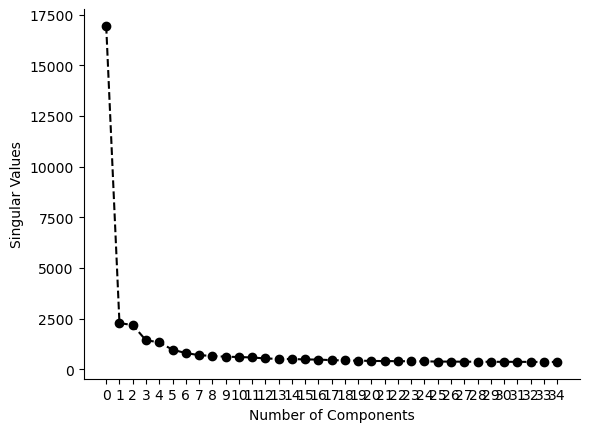

In [8]:
n_components = 35

gene_pca = get_first_n_pcs_sparse(
    X_gene, 
    n_components=n_components,
    col_prefix='gene',
)

print(f"{gene_pca.shape=}")
gene_pca.head()

iso_pca.shape=(8563, 35)


,iso1,iso2,iso3,iso4,iso5,iso6,iso7,iso8,iso9,iso10,...,iso26,iso27,iso28,iso29,iso30,iso31,iso32,iso33,iso34,iso35
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,437.082368,-7.555840,-20.348973,-29.329919,47.876285,-19.285475,-0.600627,17.512470,-20.170140,-16.725159,...,1.909067,-5.503283,-1.702808,-6.812628,-1.114577,8.579716,1.080787,0.439320,4.437133,0.012741
AAACCCAAGTTGAAGT,240.672546,-89.686605,-35.054399,-12.495694,29.431750,2.094388,1.729125,8.738413,-12.421190,2.921557,...,8.207823,9.020695,-1.021011,3.920191,-1.760610,-5.242304,-5.133860,5.246060,2.768433,-2.793375
AAACCCAAGTTGTCGT,233.056570,105.228059,159.810097,77.195398,7.437271,12.598692,12.150582,-34.547971,-30.734982,1.710345,...,-2.183320,-0.704990,2.590589,-5.467890,-3.744230,-0.784140,-8.133847,1.610529,-3.916817,-1.510842
AAACCCACAGAAGCGT,123.260804,-19.067328,36.103750,15.867989,13.837149,8.469670,28.128863,-0.639341,-19.035099,0.719002,...,-0.286745,-1.570894,-5.369016,-8.700609,1.417382,-3.463062,-4.981018,4.596776,-3.389877,-4.277485
AAACCCACAGGAGGTT,1055.842256,59.615842,-274.513517,-50.091793,52.612426,31.637306,60.365215,12.005054,26.651912,13.457506,...,-9.038473,-2.548824,-9.207092,14.871736,0.967038,-7.893470,-0.661443,-13.395869,18.549824,-6.313005


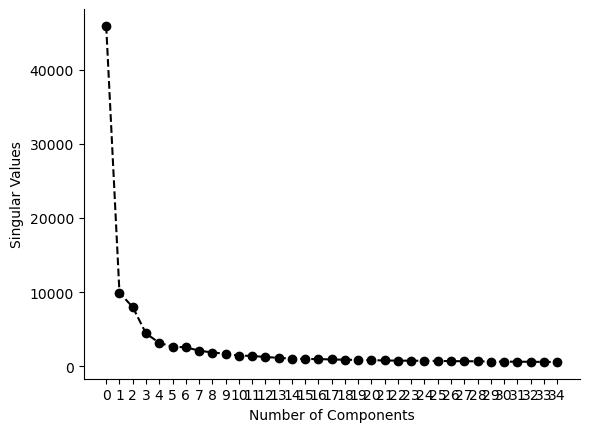

In [9]:
n_components = 35

iso_pca = get_first_n_pcs_sparse(
    X_iso, 
    n_components=n_components,
    col_prefix='iso',
)

print(f"{iso_pca.shape=}")
iso_pca.head()

# Build the feature space

In [10]:
X = pd.merge(
    gene_pca, 
    iso_pca,
    how='left',
    left_index=True,
    right_index=True,
)

print(f"{X.shape=}")
X.head()

X.shape=(8563, 70)


,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,iso26,iso27,iso28,iso29,iso30,iso31,iso32,iso33,iso34,iso35
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,192.062912,4.664567,-5.899775,-12.748454,6.426852,-1.661416,-4.134886,-11.799650,-8.566000,5.211744,...,1.909067,-5.503283,-1.702808,-6.812628,-1.114577,8.579716,1.080787,0.439320,4.437133,0.012741
AAACCCAAGTTGAAGT,183.349106,13.357903,-2.273727,-21.223257,15.253170,-4.236595,2.443233,-2.898249,1.045827,5.174258,...,8.207823,9.020695,-1.021011,3.920191,-1.760610,-5.242304,-5.133860,5.246060,2.768433,-2.793375
AAACCCAAGTTGTCGT,154.355621,-35.399368,11.251431,35.089706,11.511490,-18.121801,-1.162132,-0.923076,1.695085,2.142420,...,-2.183320,-0.704990,2.590589,-5.467890,-3.744230,-0.784140,-8.133847,1.610529,-3.916817,-1.510842
AAACCCACAGAAGCGT,150.997879,-37.394291,28.115929,-8.378047,2.574649,-13.043051,-1.152873,2.657639,5.284483,5.029523,...,-0.286745,-1.570894,-5.369016,-8.700609,1.417382,-3.463062,-4.981018,4.596776,-3.389877,-4.277485
AAACCCACAGGAGGTT,228.416718,42.371315,-3.042233,-6.099820,-20.364080,-21.253138,-5.216423,17.136566,-7.147330,-4.815832,...,-9.038473,-2.548824,-9.207092,14.871736,0.967038,-7.893470,-0.661443,-13.395869,18.549824,-6.313005


<Axes: xlabel='gene1', ylabel='iso1'>

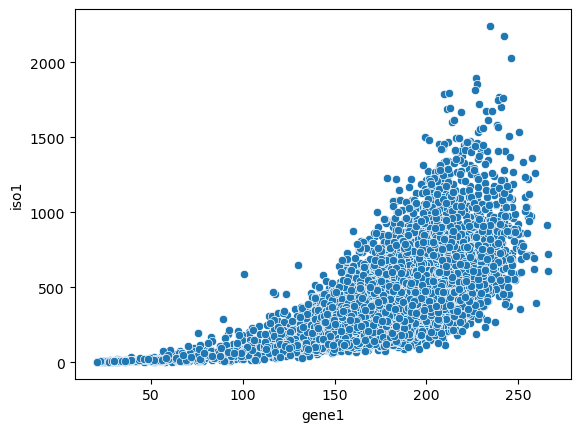

In [11]:
sns.scatterplot(
    data=X,
    x='gene1',
    y='iso1',
)

# Make a new object

In [12]:
def df_to_anndata(df):
    """
    Converts a pandas DataFrame to an AnnData object.

    Args:
        df: The pandas DataFrame to convert.

    Returns:
        An AnnData object.
    """

    adata = an.AnnData(df.values)
    adata.obs_names = df.index
    adata.var_names = df.columns

    return adata


def merge_obs(adata1, adata2):
    """
    Merges .obs from two AnnData objects based on obs_names (assumed to be the index).
    Returns a new AnnData object with the merged .obs.

    Args:
        adata1: The first AnnData object.
        adata2: The second AnnData object. .obs from this object will be merged into the new object.

    Returns:
        A new AnnData object with the merged .obs.
    """

    # Convert .obs to DataFrames
    obs1 = adata1.obs
    obs2 = adata2.obs

    # Merge DataFrames on 'obs_names' (assuming it's the index in both)
    merged_obs = pd.merge(
        obs1, 
        obs2, 
        left_index=True, 
        right_index=True, 
        how="left",
    )

    # Create a copy of adata1 to avoid modifying the original
    adata_merged = adata1.copy()

    # Assign merged .obs to the new AnnData object
    adata_merged.obs = merged_obs

    return adata_merged


pdf = df_to_anndata(X)
pdf = merge_obs(pdf, adata)
pdf

AnnData object with n_obs × n_vars = 8563 × 70
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'norm_factor'

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:12)
running Leiden clustering


/tmp/ipykernel_3498257/4124382448.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 6 clusters and added
    'iso_cluster', the cluster labels (adata.obs, categorical) (0:00:00)


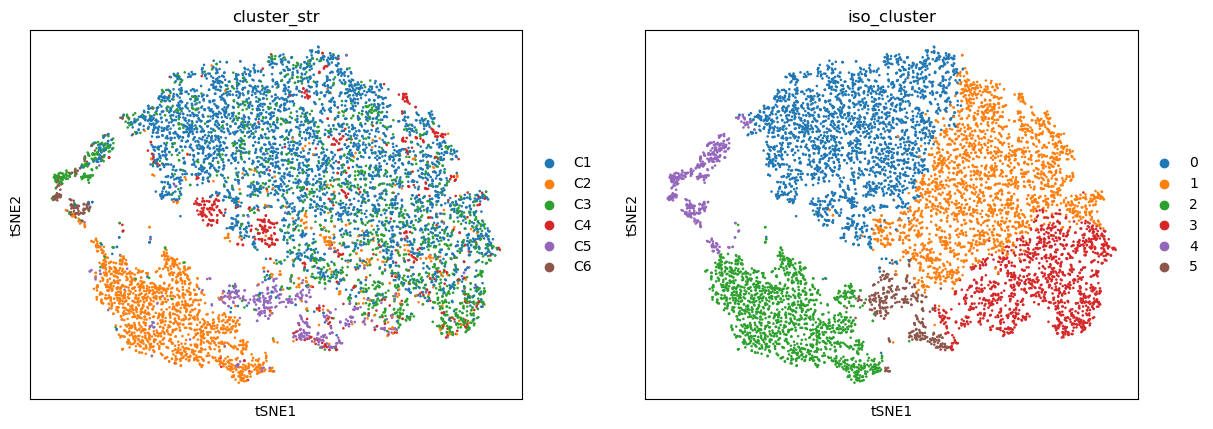

In [13]:
sc.pp.neighbors(
    pdf, 
    use_rep='X',
    n_pcs=None,
)
sc.tl.umap(pdf)
sc.tl.tsne(
    pdf,
)
sc.tl.leiden(
    pdf, 
    resolution=0.3, 
    key_added='iso_cluster',
)

sc.pl.tsne(
    pdf, 
    color=['cluster_str', 'iso_cluster'],
)

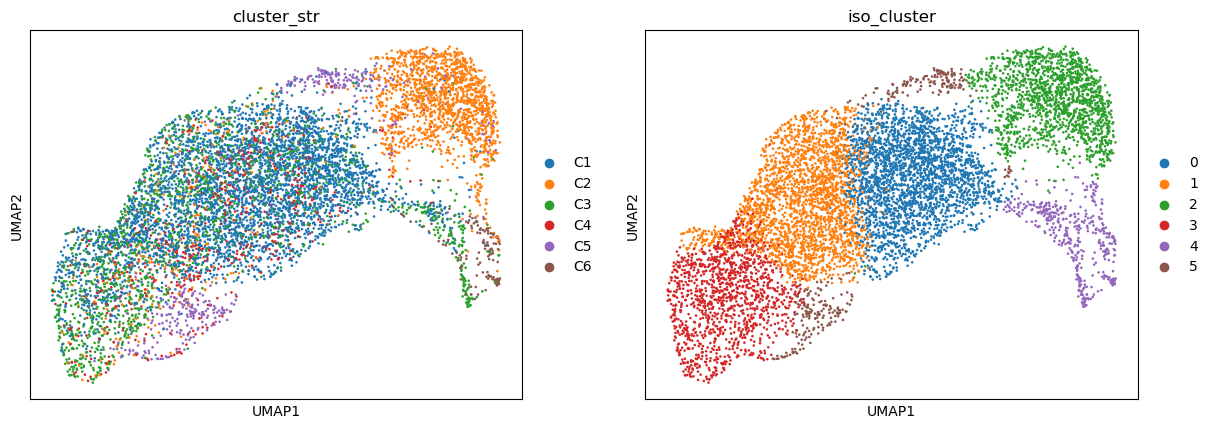

In [14]:
sc.pl.umap(
    pdf, 
    color=['cluster_str', 'iso_cluster'],
)

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)